In [57]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm 
import optuna

In [7]:
train = pd.read_csv(r'C:\Users\Cars24\Downloads\Classification with an Academic Success\data\train.csv')
test = pd.read_csv(r'C:\Users\Cars24\Downloads\Classification with an Academic Success\data\test.csv')

In [8]:
train.shape,test.shape

((76518, 38), (51012, 37))

In [9]:
train.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [11]:
# remove id columns from train and test data 

train=train.drop('id',axis = 1)
test = test.drop('id',axis =1)

In [13]:
train.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [14]:
train['Target'].value_counts()

Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

In [19]:
len(train.columns) 
X_cols = [col for col in train.columns if col != 'Target']
y_col = 'Target' 
len(X_cols)

36

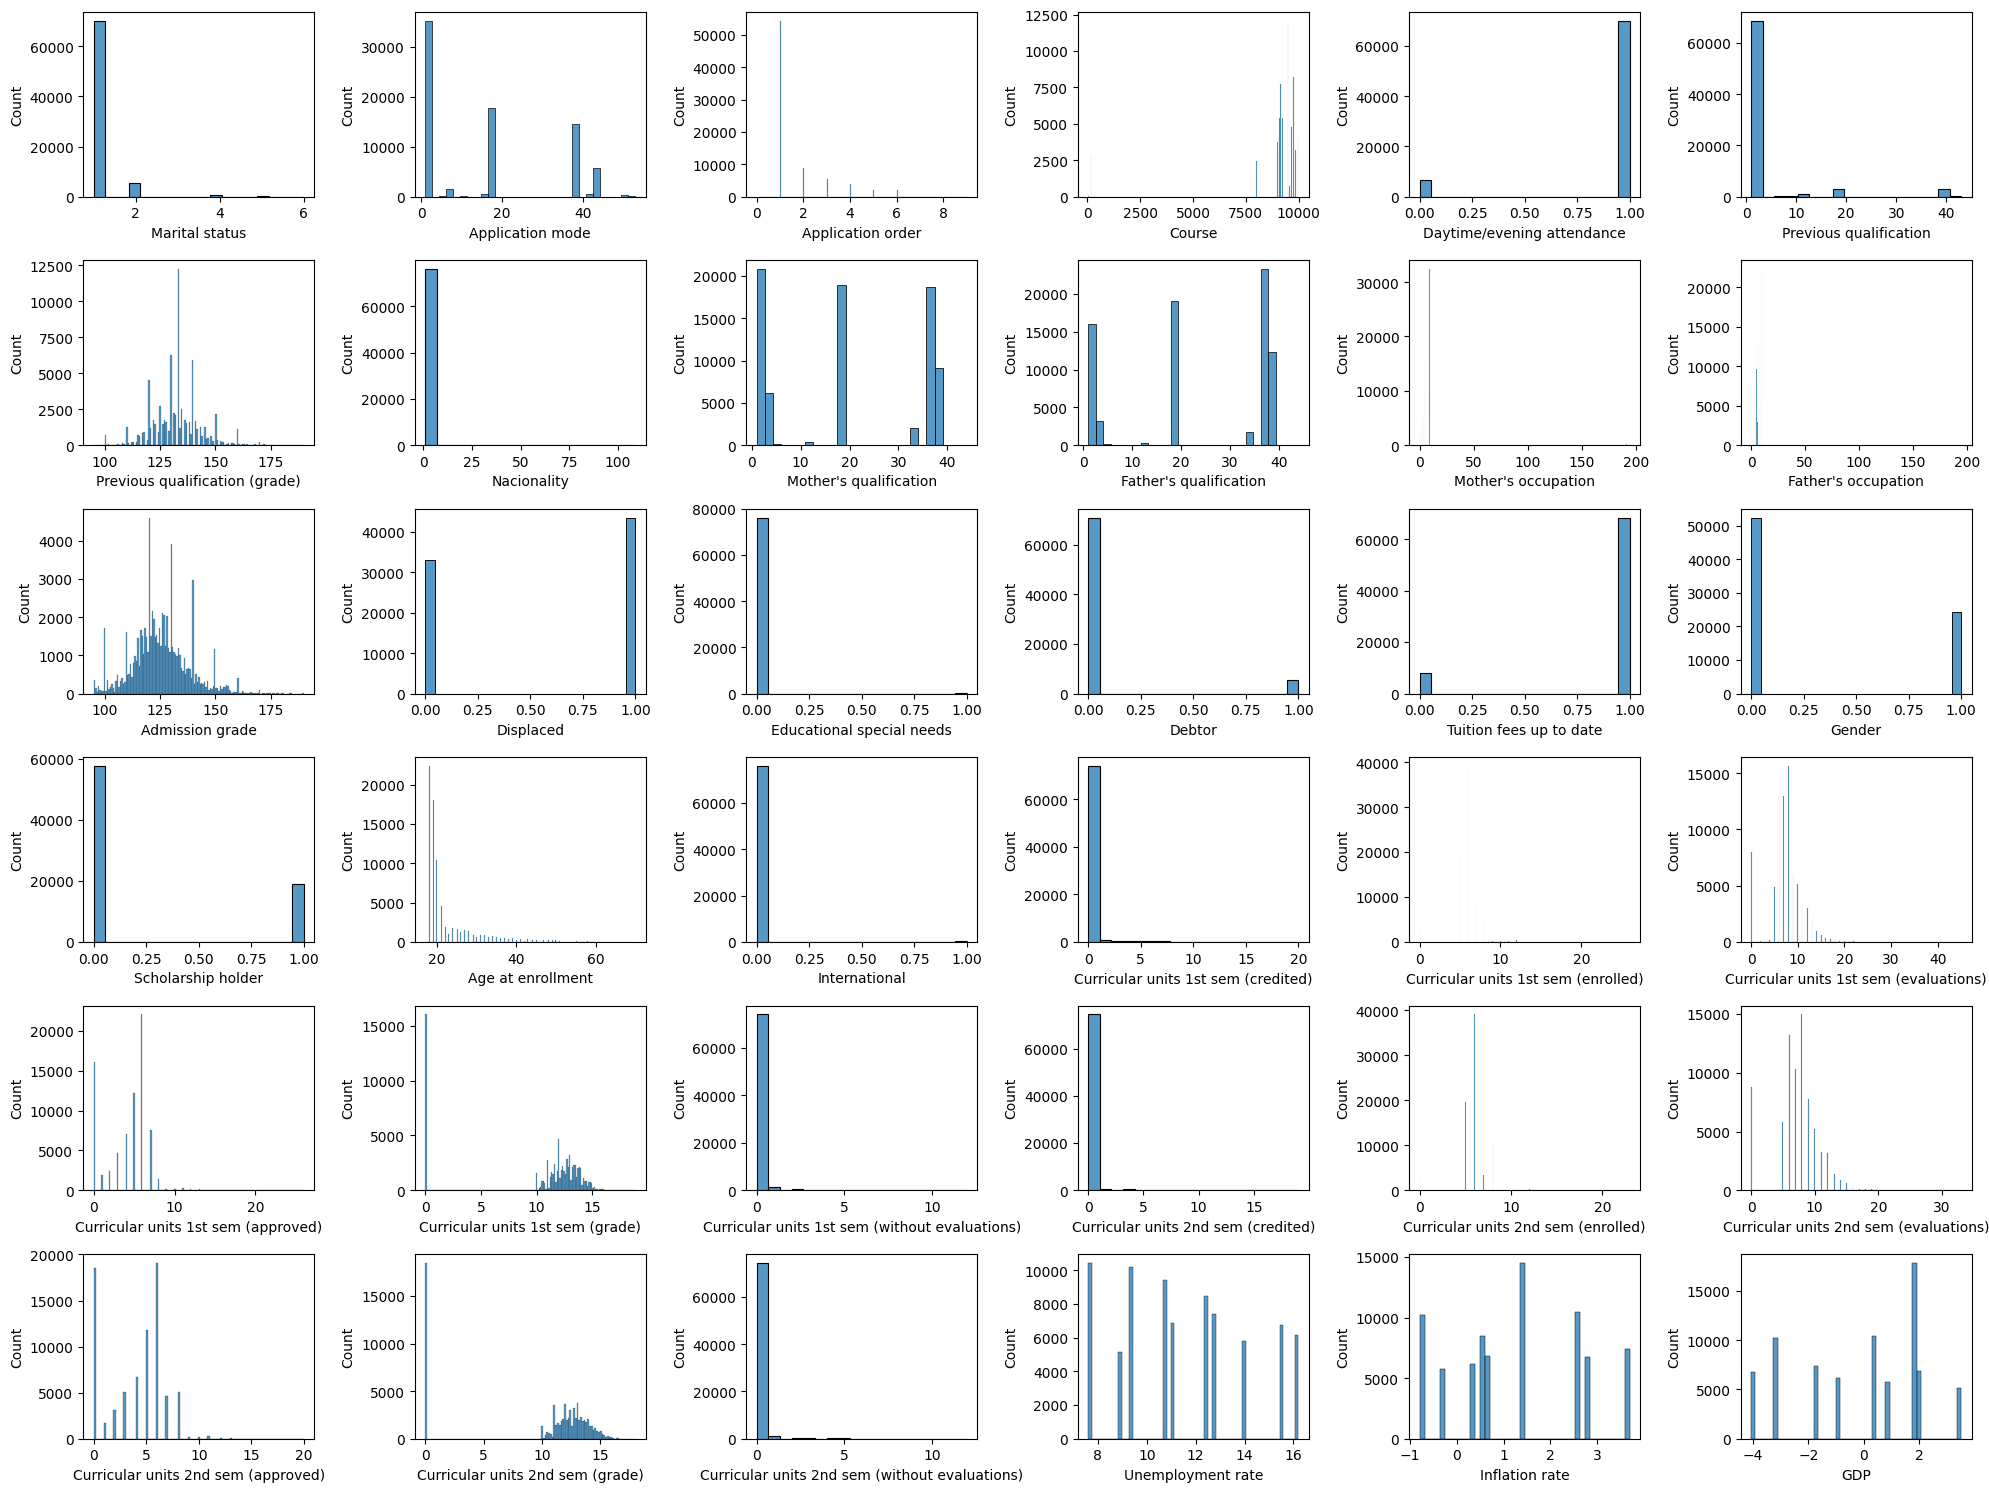

In [23]:
fig,ax = plt.subplots(ncols=6,nrows=6,figsize=(20,15))
ax = ax.flatten()
for i in range(36):
    sns.histplot(train[X_cols[i]],ax = ax[i])
    ax[i].set_xlabel(X_cols[i])
plt.tight_layout()
plt.show()

In [27]:
X = train[X_cols]
y = train[y_col]

In [29]:
selector = SelectKBest(score_func=f_classif,k=15)
reduced_data = selector.fit_transform(X,y)

In [33]:
selected_feature = selector.get_support()
selected_columns = X.columns[selected_feature]

In [35]:
reduced_data[0]

array([  1.        , 122.6       ,   0.        ,   1.        ,
         0.        ,   1.        ,  18.        ,   6.        ,
         6.        ,   6.        ,  14.5       ,   6.        ,
         7.        ,   6.        ,  12.42857143])

In [37]:
X_new = X[selected_columns]

In [45]:
label = LabelEncoder()
y_encode = label.fit_transform(y)
y_encode

array([2, 0, 0, ..., 1, 0, 2])

In [46]:
label.classes_

array(['Dropout', 'Enrolled', 'Graduate'], dtype=object)

In [58]:
kfold = KFold(n_splits=5,shuffle=True,random_state=42)
scale = StandardScaler()
rf_scores = []
gb_scores = []
xgb_scores = []

for train_idx,test_idx in tqdm(kfold.split(X_new),total=kfold.n_splits):
    X_train,X_test = X_new.iloc[train_idx],X_new.iloc[test_idx]
    y_train,y_test = y_encode[train_idx],y_encode[test_idx]
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    rf_model = RandomForestClassifier()
    rf_model.fit(X_train,y_train)
    y_pred = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test,y_pred)
    print(f'Score of rf model in {accuracy_rf}')

    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train,y_train)
    y_pred = gb_model.predict(X_test)
    accuracy_gb = accuracy_score(y_test,y_pred)
    print(f'Score of gb model in {accuracy_gb}')

    xgb_model = XGBRFClassifier()
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy_xgb = accuracy_score(y_test,y_pred)
    print(f'Score of xgb model in {accuracy_xgb}')



  0%|          | 0/5 [00:00<?, ?it/s]

Score of rf model in 0.8177600627286984
Score of gb model in 0.8239022477783586


 20%|██        | 1/5 [00:20<01:23, 20.91s/it]

Score of xgb model in 0.8148196549921589
Score of rf model in 0.821745948771563
Score of gb model in 0.8274307370622059


 40%|████      | 2/5 [00:41<01:02, 20.96s/it]

Score of xgb model in 0.8216152639832723
Score of rf model in 0.8141662310507057
Score of gb model in 0.8203084161003659


 60%|██████    | 3/5 [01:03<00:42, 21.30s/it]

Score of xgb model in 0.8122713016204913
Score of rf model in 0.8164412206756845
Score of gb model in 0.8215382604718029


 80%|████████  | 4/5 [01:28<00:22, 22.78s/it]

Score of xgb model in 0.8123897275044109
Score of rf model in 0.8155263673789453
Score of gb model in 0.8249362870025485


100%|██████████| 5/5 [01:51<00:00, 22.23s/it]

Score of xgb model in 0.8167679539959485


In [70]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',50,300)
    learning_rate = trial.suggest_float('learning_rate',0.01,0.3)
    max_depth = trial.suggest_int('max_depth',5,15)
    min_samples_split = trial.suggest_int('min_samples_split',2,12)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,15)
    subsample = trial.suggest_float('subsample',0.5,1)
    # max_features = trial.suggest_categorical('max_feature',{'auto','sqrt','log'})

    kfold = KFold(n_splits=3,shuffle=True,random_state=42)

    scale = StandardScaler()
    gb_scores = []

    for train_idx, test_idx in kfold.split(X_new):
        X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
        y_train, y_test = y_encode[train_idx], y_encode[test_idx]
        
        # Scale the data
        X_train_scaled = scale.fit_transform(X_train)
        X_test_scaled = scale.transform(X_test)
        
        # Initialize and train Gradient Boosting
        gb_model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            subsample=subsample,
            # max_features=max_features,
            random_state=42
        )
        gb_model.fit(X_train_scaled, y_train)
        y_pred_gb = gb_model.predict(X_test_scaled)
        gb_scores.append(accuracy_score(y_test, y_pred_gb))

    # Return the mean accuracy across all folds
    return np.mean(gb_scores)

In [72]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=50)

[I 2024-06-24 10:18:38,292] A new study created in memory with name: no-name-c4cfe019-c3c0-4ee7-9711-b3d4e4beb80e
[I 2024-06-24 10:29:04,472] Trial 0 finished with value: 0.8156903933127919 and parameters: {'n_estimators': 65, 'learning_rate': 0.11176031997583692, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.8573519850372701}. Best is trial 0 with value: 0.8156903933127919.
[I 2024-06-24 10:31:48,362] Trial 1 finished with value: 0.8237146750127303 and parameters: {'n_estimators': 61, 'learning_rate': 0.08262379704492492, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.5205124574152538}. Best is trial 1 with value: 0.8237146750127303.
[I 2024-06-24 10:47:38,914] Trial 2 finished with value: 0.8222770902486621 and parameters: {'n_estimators': 234, 'learning_rate': 0.01235002567680023, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8, 'subsample': 0.9845612505201247}. Best is trial 1 with value: 0.823714675012

KeyboardInterrupt: 

In [73]:
study.best_params

{'n_estimators': 255,
 'learning_rate': 0.03799816394205466,
 'max_depth': 5,
 'min_samples_split': 12,
 'min_samples_leaf': 14,
 'subsample': 0.9164457669640189}